# ADC to TOT cross-calibration with charge injections

This notebooks shows an example of using a correction curve, based on charge injection data, to perform ADC-TOT cross-calibration on run 300 data. This is just one well-behaving example channel. 

In [2]:
!pip install -r ../requirements.txt

import sys
sys.path.append('../src')
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap
import math
from chargeInjections import calibrationCurve

from selectCleanEvents import *

# Choose a channel

In [3]:
layer = 6
strip = 3
end = 1

In [5]:
#Conversion from layer-strip-end indexing to backplane-link-channel indexing

f = open("../chargeinjections/map.csv","r")

mapping = {}

for line in f:
    #print(line)
    s = line.split(",")
    if s[0] != "DPM":    
        s = [int(p) for p in s]
        physical = (s[3],s[4],s[5])
        electronic = (s[0],s[1],s[2])
        #print(physical)    
        mapping[physical] = electronic

eid = mapping[(layer,strip,end)]

dpm = eid[0]
ilink = eid[1]
ch = eid[2]


In [6]:
#Read some data
electrons0p5GeV = pd.read_csv('../analysis_files/run_302_aligned.csv')
muons = pd.read_csv('../analysis_files/run_287_aligned.csv')
electrons4GeV = pd.read_csv('../analysis_files/run_300_aligned.csv')

# This reads the charge injection csv file and returns:
- The TOT threshold in units of charge (not always very useful)
- The TOT threshold in in units of TOT (it has a pedestal)
- a function *TOTcurve*, injected charge vs TOT
- The linear fit to the low capactitor charge injections, injected charge vs sumADC, that we use as a baseline

['scan_DPM0_CALIBRUN_coff14_20220419_073825.csv', 'calibration.py', 'scan_DPM1_CALIBRUN_coff14_20220424_071550.csv', 'map.csv', 'scan_DPM0_CALIBRUN_coff14_20220424_071302.csv', 'scan_DPM1_CALIBRUN_coff14_20220424_220543.csv', 'scan_DPM1_CALIBRUN_coff14_20220419_081316.csv', 'testbeam_connections_Apr13.csv', 'scan_DPM0_CALIBRUN_coff14_20220424_220633.csv']
Linear fit to low. cap charge injections:
1.8395926042967496*x + 842.1030337424947
popt
[2.80366743e-01 5.48468725e+02]
Poptpower
[8294.56988651  843.17487431]
0.2803667433389301*x + 548.4687250778983 - 8294.569886513982/(x-843.1748743103369)
ADC Sum line
[  1.8395926  842.10303374]
Fit parameters:
[2.80366743e-01 5.48468725e+02]
[8294.56988651  843.17487431]
Charge threshold884.1031246115883
Threshold: 602.3333333333334


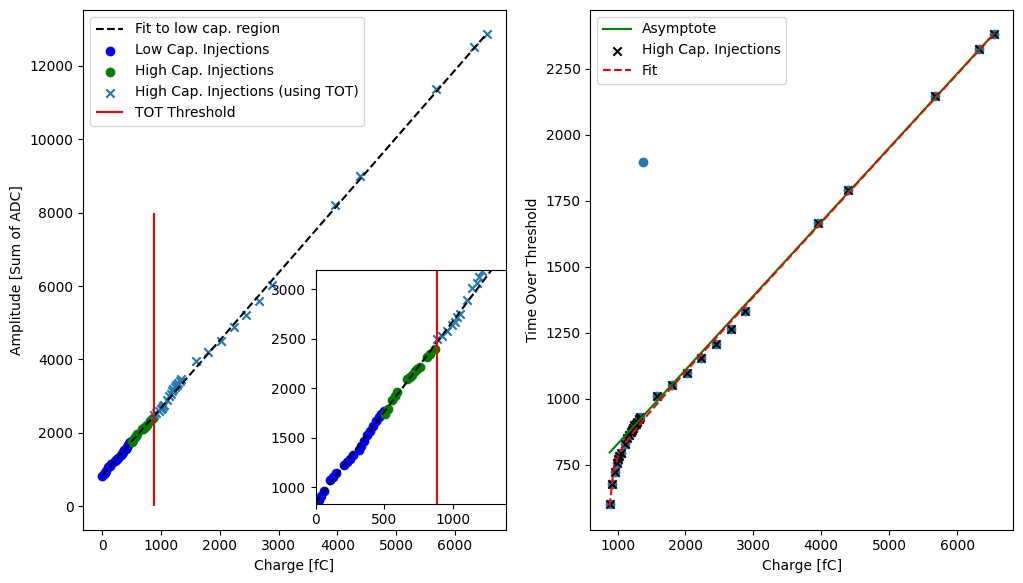

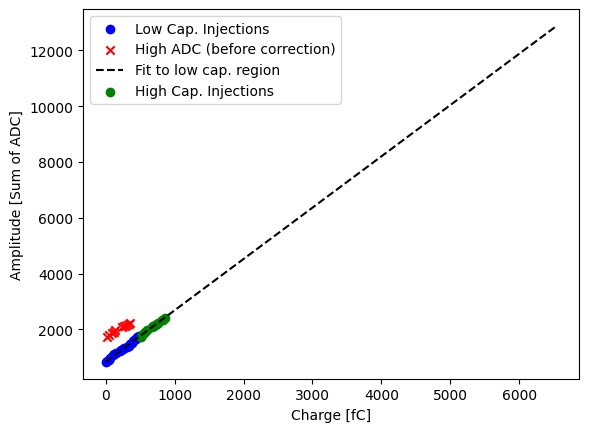

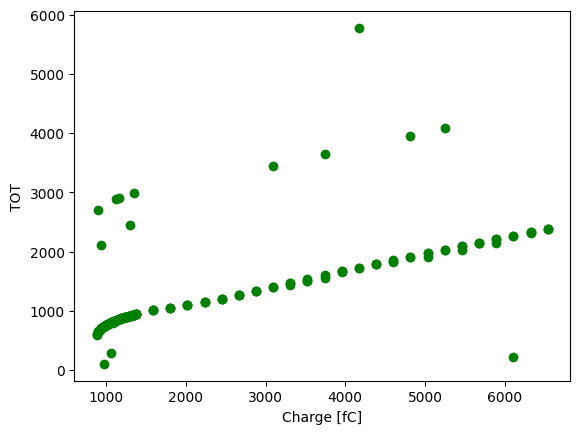

0.2803667433389301*x + 548.4687250778983 - 8294.569886513982/(x-843.1748743103369)
1.8395926042967496*x + 842.1030337424947


In [34]:
chargethreshold, totthreshold, TOTcurve, linearfit = calibrationCurve(dpm,ilink,ch,
                                                                      "../chargeinjections/scan_DPM0_CALIBRUN_coff14_20220424_220633.csv")

TOT Threshold (in units of TOT
593.6806006252096


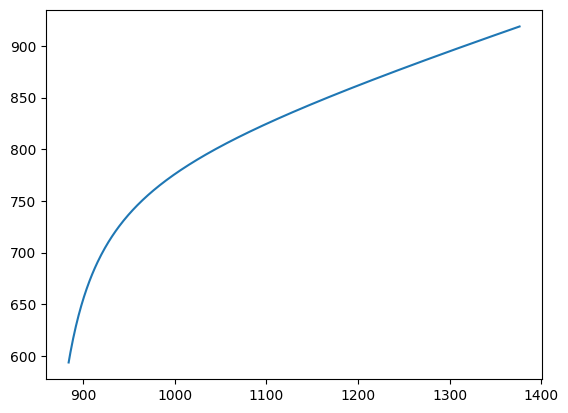

In [35]:
#Plotting the TOT curve
x = np.linspace(chargethreshold,64000,64001)
y = [TOTcurve(p) for p in x[:500]]
plt.plot(x[:500],y)

#TOT threshold in units of TOT
print("TOT Threshold (in units of TOT")
print(totthreshold)

#Here we create the conversion look-up table! 
TOTs = [TOTcurve(p) for p in x]
sumADCs = [linearfit(p) for p in x] 

The TOT pedestal in data seems to be higher than in charge injections, so we look at the muon data and update the TOT threshold accordingly. 

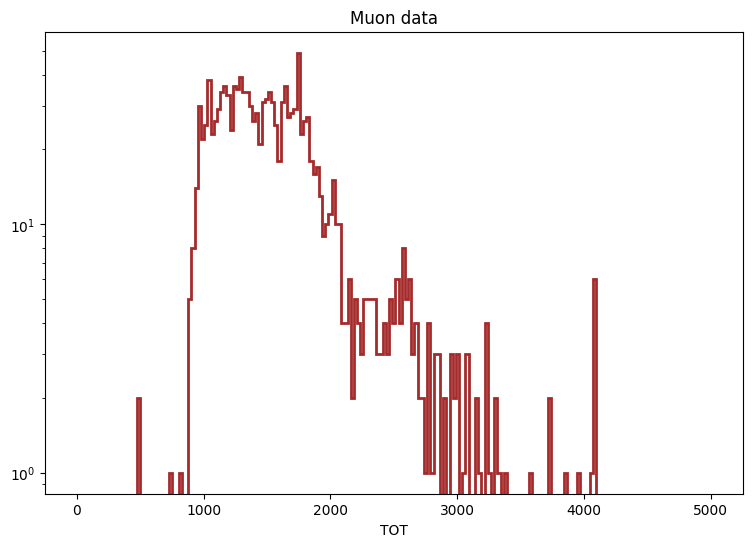

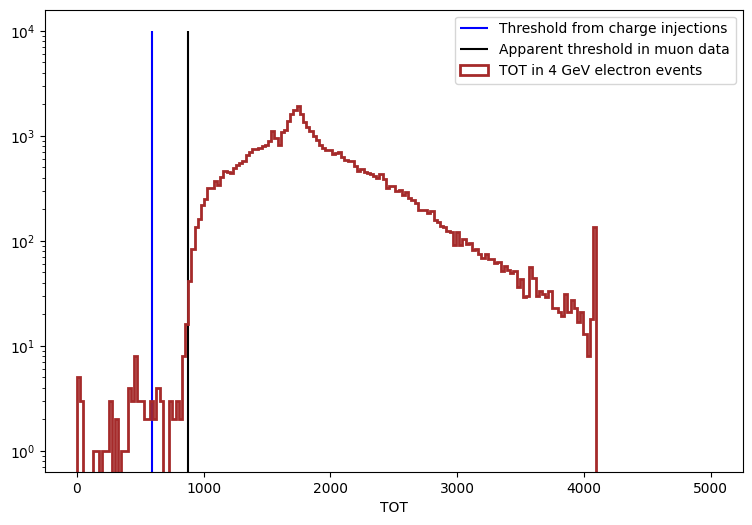

In [36]:
events = muons.loc[muons['layer'] == layer].loc[muons['strip'] == strip]

bins = np.linspace(0,5000,200)
totraw = []
for index, row in events.iterrows():
    #If TOT is below the TOT threshold, use only ADC data
    if end == 0:
        if row['tot_end0'] > 0:
            totraw.append(row['tot_end0'])
    else:
        if row['tot_end1'] > 0:
            totraw.append(row['tot_end1'])

hist, hist_edges = np.histogram(totraw, bins)

newthreshold = 0

for i in range(0,len(hist_edges)):
    if hist[i] >= 3:
        newthreshold = hist_edges[i]
        break

fig = plt.figure(figsize=(9,6))

plt.title("Muon data")
plt.yscale("log")
plt.xlabel("TOT")
plt.hist(totraw, bins=bins, histtype="step", color="brown", label="TOT in muon events", linewidth=2)

events = electrons4GeV.loc[electrons4GeV['layer'] == layer].loc[electrons4GeV['strip'] == strip]

totraw = []
for index, row in events.iterrows():
    if end == 0:
        if row['tot_end0'] > 0:
            totraw.append(row['tot_end0'])
    else:
        if row['tot_end1'] > 0:
            totraw.append(row['tot_end1'])

fig = plt.figure(figsize=(9,6))

bins = np.linspace(0,5000,200)

plt.vlines(totthreshold,0,10000, label="Threshold from charge injections", color="blue")
plt.vlines(newthreshold,0,10000, label="Apparent threshold in muon data", color="black")
plt.yscale("log")
plt.xlabel("TOT")
plt.hist(totraw, bins=bins, histtype="step", color="brown", label="TOT in 4 GeV electron events", linewidth=2)
plt.legend()

totthreshold = newthreshold

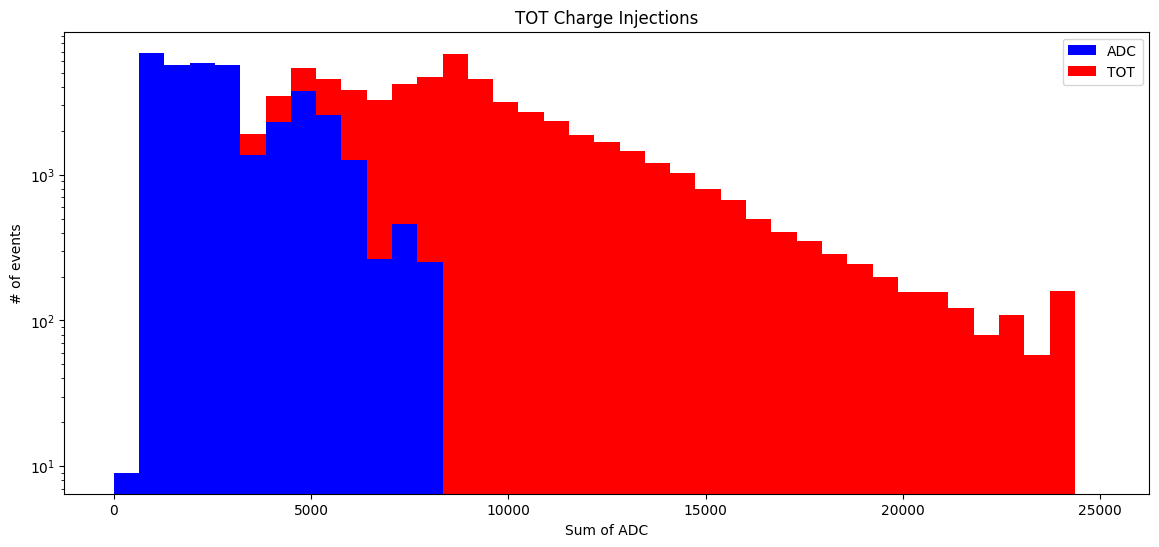

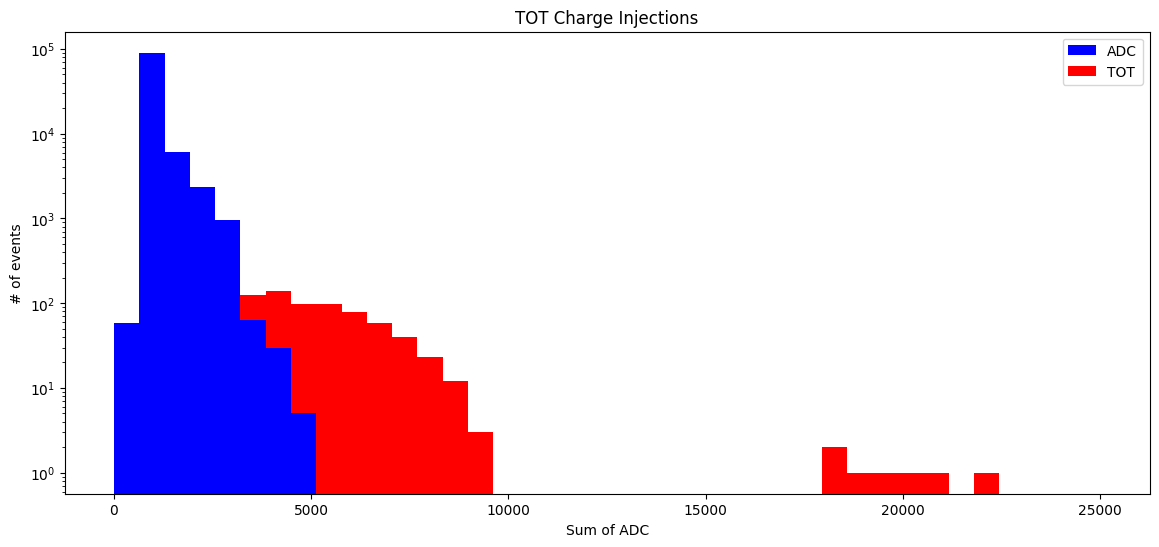

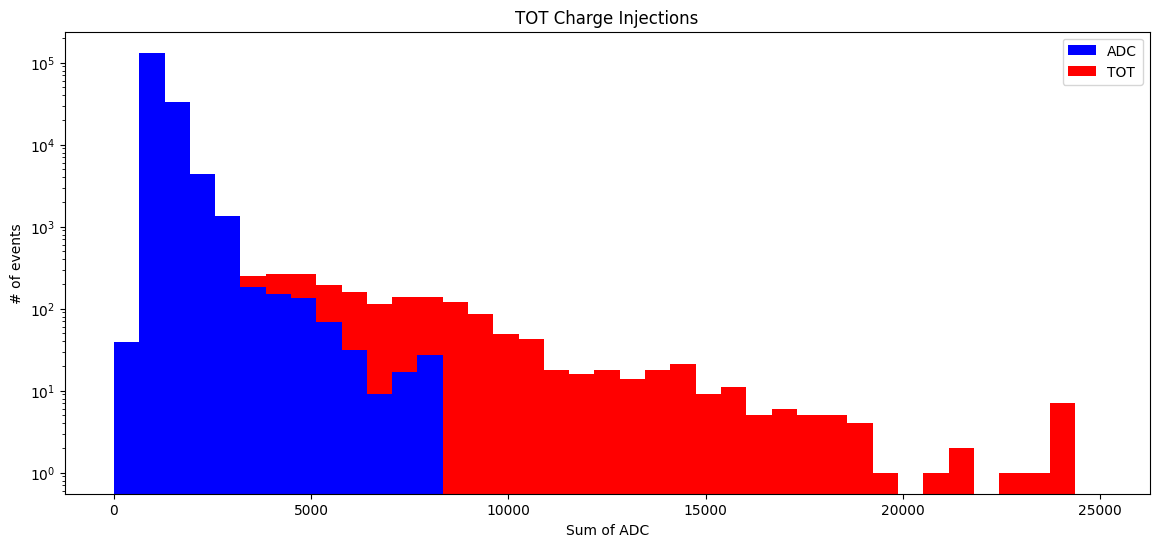

In [37]:
#Plot the results for some different datasets

for i,data in enumerate([electrons4GeV, electrons0p5GeV, muons]):

    events = data.loc[data['layer'] == layer].loc[data['strip'] == strip]

    #Pure ADC events
    adcsum = []
    #TOT events (converted into sum of ADC)
    totcorrected = []
    
    for index, row in events.iterrows():
        #If TOT is below the TOT threshold, use only ADC data
        if end == 0:
            if row['tot_end0'] < totthreshold:
                adcsum.append(row['adc_sum_end0'])
            else:
                t = row['tot_end0']
                #Use conversion table to go from TOT to ADC sum
                index = 0
                for i in range(0,len(TOTs)):
                    if TOTs[i] >= t:
                        index = i
                        break
                totcorrected.append(sumADCs[i])
        else:
            if row['tot_end1'] < totthreshold:
                adcsum.append(row['adc_sum_end1'])
            else:
                t = row['tot_end1']
                #Use conversion table to go from TOT to ADC sum
                index = 0
                for i in range(0,len(TOTs)):
                    if TOTs[i] >= t:
                        index = i
                        break
                totcorrected.append(sumADCs[i])

    bins = np.linspace(0,25000,40)
    fig,ax = plt.subplots(1,1,figsize=(14,6))
    labels = ["ADC", "TOT"]
    ax.hist([adcsum, totcorrected],bins=bins,histtype="barstacked",label=labels, facecolor=["blue","red"])
    ax.set_yscale("log")
    ax.set_title("TOT Charge Injections")
    ax.set_xlabel("Sum of ADC")
    ax.set_ylabel("# of events")
    plt.legend()
    plt.show()